# UPLOADING USEFUL DATA

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import sys
import json
import time
from shapely.geometry import box,LineString,Point,MultiPoint,MultiLineString,MultiPolygon,Polygon
from shapely.ops import unary_union
import socket
from collections import defaultdict
from numba import prange
import gc
current_dir = os.path.join(os.getcwd()) 
mother_path = os.path.abspath(os.path.join(current_dir, os.pardir))
print('mother_path:', mother_path)
sys.path.append(os.path.join(mother_path, 'PreProcessing'))
sys.path.append(os.path.join(mother_path))
from FittingProcedures import *
from plot import *
from Potential import *
from Grid import *
from PreprocessingObj import *
from ODfromfma import *
import time
from GeometrySphere import *
from Polycentrism import *
from PolycentrismPlot import *
from ModifyPotential import *
from MainPolycentrism import *
from GravitationalFluxes import *
#import rustworkx as rw
import ast
## BASIC PARAMS
#gc.set_threshold(10000,50,50)
plt.rcParams.update({
    "text.usetex": False,
})

if socket.gethostname()=='artemis.ist.berkeley.edu':
    TRAFFIC_DIR = '/home/alberto/LPSim/traffic_phase_transition'
else:
    TRAFFIC_DIR = os.getenv('TRAFFIC_DIR')
def MainComputationGravitationalFit(name,grid_size,hexagon_resolution,dir_grid):
    ## BASIC NEEDED OBJECTS
    SFO_obj = GeometricalSettingsSpatialPartition(name,TRAFFIC_DIR)
    bbox = SFO_obj.bounding_box
    minx, miny, maxx, maxy = bbox
    dir_geometries = os.path.join(TRAFFIC_DIR,'data','carto','{0}'.format(name))
    grid = GetGrid(grid_size,SFO_obj.bounding_box,'EPSG:4326',dir_geometries)
    grid = GetBoundariesInterior(grid,SFO_obj)
    df_distance,FoundDistMat = GetDirectionMatrix(dir_geometries,grid_size)
    Tij = GetODGrid(dir_geometries,str(grid_size))
    lattice = nx.read_graphml(os.path.join(dir_grid,"centroid_lattice.graphml"))

    cartodir = os.path.join(TRAFFIC_DIR,'data','carto','BOS')
    dirgrid = os.path.join(cartodir,'grid')
    potentialdir = os.path.join(cartodir,'potential')
    VespignaniBlock(df_distance,grid,Tij,potentialdir)

names = ['SFO','LIS','RIO','LAX']
grid_size = 0.02
hexagon_resolution = 8
dir_grids = [os.path.join(TRAFFIC_DIR,'data','carto',name,'grid',str(grid_size)) for name in names]

for cityidx in range(len(names)):
    MainComputationGravitationalFit(names[cityidx],grid_size,hexagon_resolution,dir_grids[cityidx])    




# FIT VESPIGNANI

mean:  [7.2320013, 7.0880876, 6.9325275, 6.934004, 6.84578, 6.6607647, 6.6047907, 6.4213023, 6.3232856, 6.256113, 6.008764, 5.918116, 5.7829194, 5.7228985, 5.806626, 5.842546, 5.9327645, 5.9527874, 6.071553, 5.8641906, 5.4670453, 5.570338, 4.816491, 4.3666897, 3.7942514, 3.5213888, 3.392092, 2.643536, 2.640894, 2.3188539, 2.0200596, 1.4424229, 1.8752114, 1.3104993, 1.5076199, 1.0127455, 0.9847065, 0.55372775, 0.48889685, -0.24188054, -1.003944, -1.4897736, -0.9189634, -0.96529424, -1.251704, -1.7169739, -0.47407365, -2.0388575, -2.3068857, -2.5499167]
Distr mean:  (50,)
Distr error:  (50,)
Mean Model:  [7.24701929 7.10272789 6.94682455 6.94845963 6.86013365 6.67471075
 6.61868238 6.43478298 6.3365736  6.26938105 6.02152538 5.93077374
 5.79526854 5.73523951 5.81936026 5.8555131  5.94615126 5.96634817
 6.0855155  5.87771606 5.47946405 5.58305407 4.82740164 4.3762145
 3.80215716 3.52879047 3.39872479 2.6487844  2.64602232 2.32335806
 2.02385044 1.44503272 1.87884593 1.31317198 1.5104872  

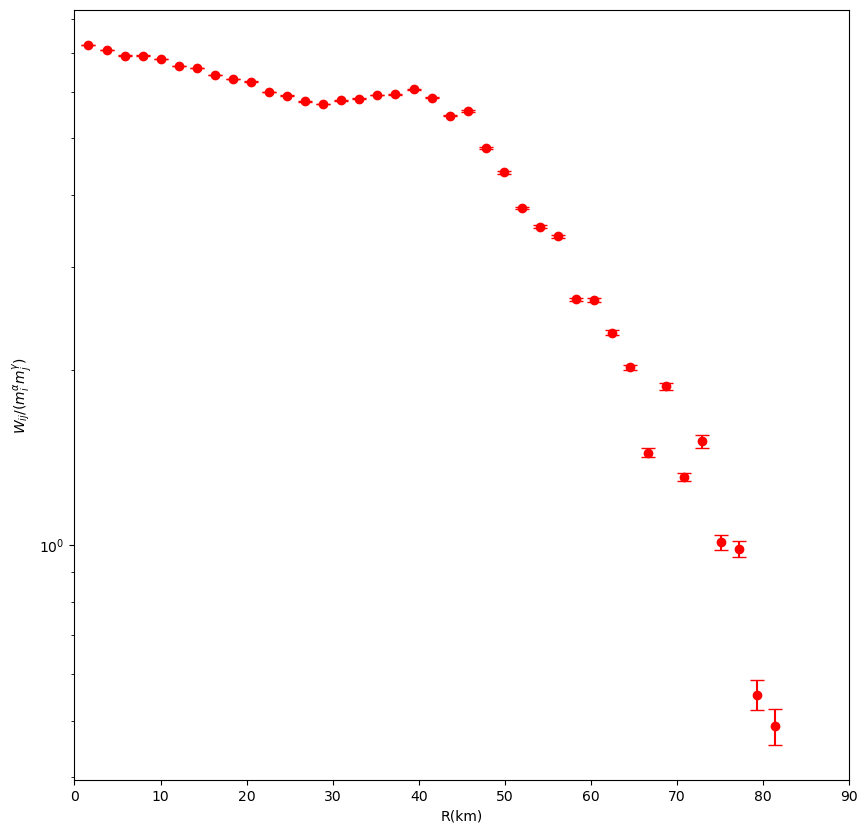

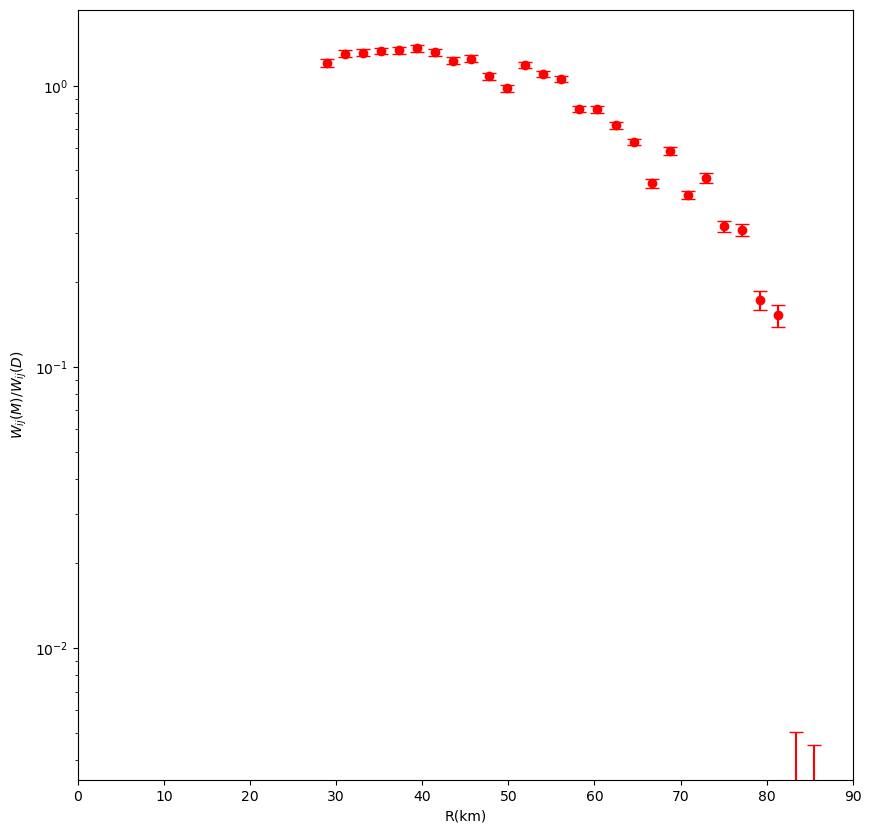

In [ ]:
cartodir = os.path.join(TRAFFIC_DIR,'data','carto','BOS')
dirgrid = os.path.join(cartodir,'grid')
potentialdir = os.path.join(cartodir,'potential')
with open(os.path.join(potentialdir,'FitVespignani.json'),'r') as f:
    d = json.load(f)
k = [d['logk'],d['alpha'],d['gamma'],d['1/d0']]
# TAKE THE DISTRIBUTION OF FLUXES COLLECTING BY DISTANCE BINS
n,bins = np.histogram(VespignaniVector[2],bins = 50)
#nDist, binsDist = np.histogram(VespignaniVector[0],bins = 50)

# PLOT '$W_{ij}/(m_i^{{\\alpha}} m_j^{{\\gamma}})$'

EstimatedVectorFluxesVespignani = multilinear4variables(VespignaniVector,k[0],k[1],k[2],k[3])
WOverMM = [EstimatedVectorFluxesVespignani[np.where(((VespignaniVector[2]>bins[i]) & (VespignaniVector[2] < bins[i+1])))]/(VespignaniVector[0][np.where(((VespignaniVector[2]>bins[i]) & (VespignaniVector[2] < bins[i+1])))]**k[0]*VespignaniVector[1][np.where(((VespignaniVector[2]>bins[i]) & (VespignaniVector[2] < bins[i+1])))])**k[1] for i in range(len(bins)-1)]
error = [np.std(WOverMM[i])/np.sqrt(len(WOverMM[i])) for i in range(len(WOverMM))]
mean = [np.mean(WOverMM[i]) for i in range(len(WOverMM))]
print('mean: ',mean)
print('Distr mean: ',np.shape(mean))
print('Distr error: ',np.shape(error))


# PLOT '$W_{ij} (M)/W_{ij} (D)$'
WM = [EstimatedVectorFluxesVespignani[np.where(((VespignaniVector[2]>bins[i]) & (VespignaniVector[2] < bins[i+1])))] for i in range(len(bins)-1)]
WD = [Fluxes[np.where(VespignaniVector[0]>bins[i]) and VespignaniVector[0] < bins[i+1]] for i in range(len(bins)-1)]
meanWM = np.array([np.mean(WM[i]) if np.mean(WM[i])>0 else 0 for i in range(len(WM))] )
errorWM = np.array([np.std(WM[i])/np.sqrt(len(WM[i])) for i in range(len(WM))]) 
meanWD = np.array([np.mean(WD[i]) for i in range(len(WD))]) 
errorWD = np.array([np.std(WD[i])/np.sqrt(len(WD[i])) for i in range(len(WD))]) 

print('Mean Model: ',meanWM)
print('mean Model smaller 0: ',np.shape([meanWM<0]))
print('mean Data smaller 0: ',np.shape(meanWD[meanWD<0]))
print('error Model smaller 0: ',np.shape(errorWM[errorWM<0]))
print('error Data smaller 0: ',np.shape(errorWD[errorWD<0]))


WMoverWD = meanWM/meanWD
error1 = errorWM/meanWD + meanWM/(meanWD)**2*errorWD 


print('Distr W(M)/W(D): ',np.shape(WMoverWD))
print('Distr error1: ',np.shape(error1))


# PLOTTING
fig,ax = plt.subplots(1,1,figsize = (10,10))
plt.errorbar(bins[:-1],mean,yerr = error, fmt='o', capsize=5, color='red')
plt.yscale('log')
plt.xlim(0,90)
plt.xlabel('R(km)')
plt.ylabel('$W_{ij}/(m_i^{{\\alpha}} m_j^{{\\gamma}})$')
plt.savefig(os.path.join(potentialdir,'PlotFitVespignani.png'),dpi = 200)
plt.show()

fig,ax = plt.subplots(1,1,figsize = (10,10))
plt.errorbar(bins[:-9],WMoverWD[:-8],yerr = error1[:-8], fmt='o', capsize=5, color='red')
plt.yscale('log')
plt.xlabel('R(km)')
plt.xlim(0,90)
plt.ylabel('$W_{ij} (M)/W_{ij} (D)$')
plt.savefig(os.path.join(potentialdir,'PlotFitVespignaniDataModel.png'),dpi = 200)
plt.show()


# POPULATION FIT

In [ ]:
# TODO: Suppose you have a population distribution that is an exponential with fitting parameter m0. I want to redistribute the mass in such a way
# that I take favor the big population, then I fix 

import matplotlib.patches as patches
n,bins = np.histogram(grid['population'].to_numpy(),bins = 40)
# FILTER MASS
def FilterPercentageCumulative(perc,n,bins):
    total_sum = np.sum(n) 
    cumulative_sum = np.cumsum(n)
    index_95_percent = np.argmax(cumulative_sum >=  perc* total_sum)
    # Select the elements that contain 95% of the sum
    n = n[:index_95_percent + 1]
    bins = bins[:index_95_percent + 1]
    return n,bins
start_bin = 1
end_bin = 0

if len(n) == len(bins):
    m0 = (bins[-end_bin] - bins[start_bin])/np.log(n[start_bin]/n[-end_bin])
    Aend = n[-end_bin]*np.exp(bins[-end_bin]/m0)
    Astart = n[start_bin-1]*np.exp(bins[start_bin]/m0)
    ResultFit = Fitting(bins[start_bin:-end_bin],n[start_bin:-end_bin],label = 'powerlaw',initial_guess = (11,-1.83),maxfev = 10000)
    coefficients = np.polyfit(bins[start_bin:-end_bin],np.log(n[start_bin:-end_bin]), 1)
    poly_function = np.poly1d(coefficients)
    y_fit = poly_function(bins[start_bin:-end_bin])
    plt.scatter(bins[start_bin:-end_bin],n[start_bin:-end_bin])
    plt.plot(bins[start_bin:-end_bin],y_fit)
#    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    print(coefficients)

else:
    ResultFit = Fitting(bins[start_bin:],n[start_bin-1:],label = 'powerlaw',initial_guess = (11,-1.83),maxfev = 10000)
    plt.scatter(bins[start_bin:],n[start_bin-1:])
    plt.plot(bins[start_bin:],bins[start_bin:]**ResultFit[0][1]*ResultFit[0][0])
    plt.xlabel('m (Population)')
    plt.ylabel('Distribution')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Power law fit')# = {}'.format(round(ResultFit[0][1],2)))
    plt.savefig(os.path.join(dir_grid,'PopulationDistribution.png'),dpi = 200)
    plt.show()
    with open('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/potential/FitPlMass.json','r') as f:
        json.dump({'A':ResultFit[0][0],'b':ResultFit[0][1]})

#A, m0 = ResultFit[0],ResultFit[1]
#iterations = len(grid['population'].to_numpy())
#amplifications = np.arange(0.1,10,100)
#for amp in amplifications:
#    ModifyPop(grid['population'],A,m0,amp*m0)


In [ ]:
print('Total population: ',np.sum(grid['population']),' Moving population: ',np.sum(Tij['number_people']),'Fraction people moving from population: ',np.sum(Tij['number_people'])/np.sum(grid['population']))

Total population:  4546481.94410453  Moving population:  681885 Fraction people moving from population:  0.14998080018424076


# PLOT POTENTIAL AND VECTOR FIELDS 

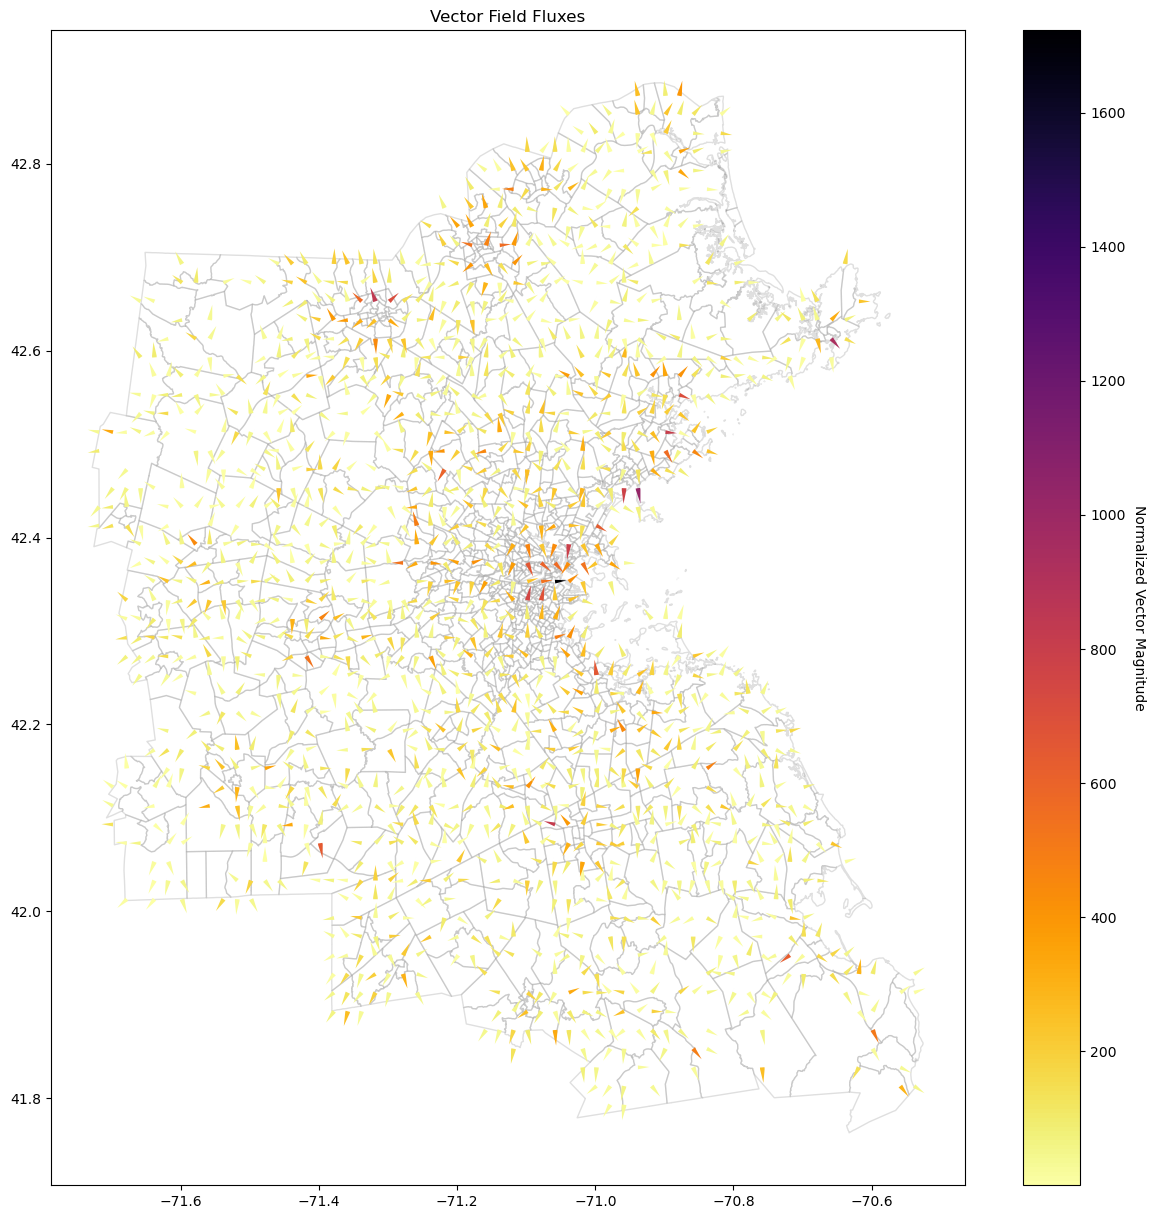

Text(0.5, 1.0, 'Vector Field Fluxes')

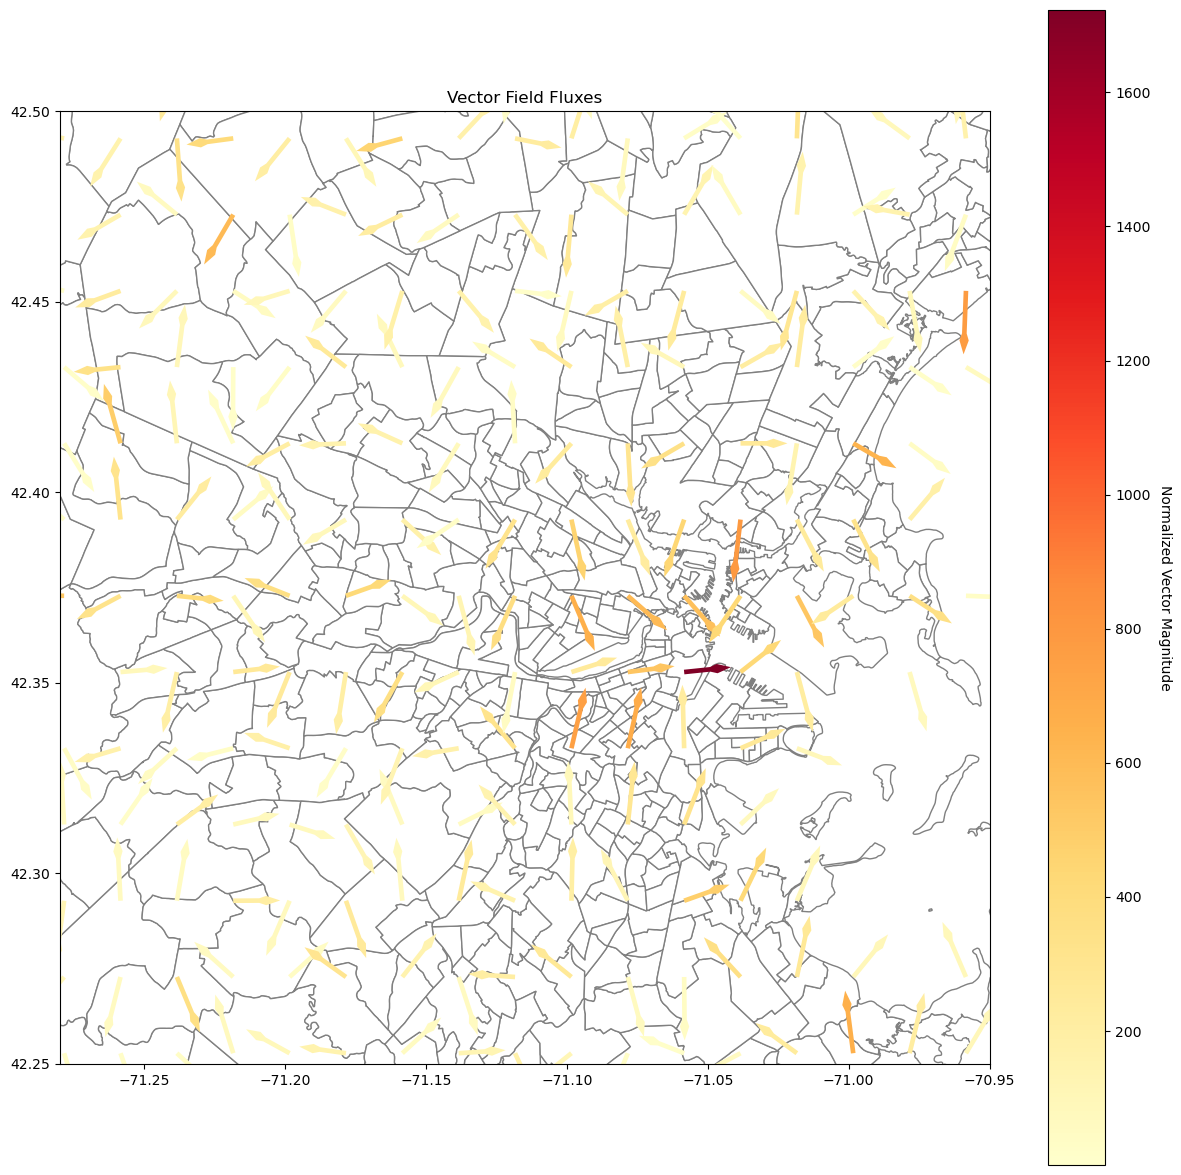

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
SFO_obj.gdf_polygons.plot(ax=ax, color='white', edgecolor='grey',alpha = 0.25)
centroid_coords = np.array([grid['centroidx'].to_numpy(),grid['centroidy'].to_numpy()])
centroid_coords = centroid_coords.T
#grav_vector_field = gravitational_field(fluxes_matrix,normalized_vectors,nv)
VF = np.stack(VectorField['Tj'].to_numpy(dtype = np.ndarray))
VF_norm = np.linalg.norm(VF, axis=1)
VF_normalized = np.stack(np.array([VF[i] / VF_norm[i] if VF_norm[i] !=0 else [0, 0] for i in range(len(VF_norm))]))
mask = [True if VF_norm[i]!=0 else False for i in range(len(VF_norm))]
quiver_plot = ax.quiver(centroid_coords[mask,0], centroid_coords[mask,1], VF_normalized[mask,0], VF_normalized[mask,1],
        VF_norm[mask], cmap='inferno_r', angles='xy', scale_units='xy', scale=60, width=0.005,headwidth=1, headlength=3)
quiver_cbar = plt.colorbar(quiver_plot, ax=ax)
quiver_cbar.set_label('Normalized Vector Magnitude', rotation=270, labelpad=15)
ax.set_title('Vector Field Fluxes')
plt.savefig(os.path.join(os.getcwd(),'VectorField.png'))
plt.show()
fig, ax = plt.subplots(figsize=(15, 15))
SFO_obj.gdf_polygons.plot(ax=ax, color='white', edgecolor='grey',alpha = 1)
centroid_coords = np.array([grid['centroidx'].to_numpy(),grid['centroidy'].to_numpy()])
centroid_coords = centroid_coords.T
#grav_vector_field = gravitational_field(fluxes_matrix,normalized_vectors,nv)
VF = np.stack(VectorField['Tj'].to_numpy(dtype = np.ndarray))
VF_norm = np.linalg.norm(VF, axis=1)
VF_normalized = np.stack(np.array([VF[i] / VF_norm[i] if VF_norm[i] !=0 else [0, 0] for i in range(len(VF_norm))]))
mask = [True if VF_norm[i]!=0 else False for i in range(len(VF_norm))]
quiver_plot = ax.quiver(centroid_coords[mask,0], centroid_coords[mask,1], VF_normalized[mask,0], VF_normalized[mask,1],
        VF_norm[mask], cmap='YlOrRd', angles='xy', scale_units='xy', scale=60, width=0.005,headwidth=2, headlength=3)
quiver_cbar = plt.colorbar(quiver_plot, ax=ax)
quiver_cbar.set_label('Normalized Vector Magnitude', rotation=270, labelpad=15)
ax.set_xlim(-71.28,-70.95)
ax.set_ylim(42.25,42.5)
plt.savefig(os.path.join(os.getcwd(),'VectorFieldZoom.png'))
ax.set_title('Vector Field Fluxes')



### Contour Plot and 3D Potential

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#VectorField = pd.read_csv('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/grid/0.02/VectorField.csv')
#PotentialDataframe = pd.read_csv('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/grid/0.02/PotentialDataFrame.csv')
def PotentialContour(grid,PotentialDataframe,SFO_obj,dir_grid):
    # Assuming you have a GeoDataFrame named 'grid' with a 'geometry' column containing polygons and a 'potential' column
    if 'potential' in grid.columns:
        pass
    else:
        grid['potential'] = PotentialDataframe['V_out']    
    grid['potential'] = PotentialDataframe['V_out']
    # Create a contour plot
    fig, ax = plt.subplots(figsize=(20, 20))
    SFO_obj.gdf_polygons.plot(ax=ax, color='white', edgecolor='black',alpha = 0.2)
    grid.plot(ax=ax, edgecolor='black', facecolor='none',alpha = 0.2)
    contour_filled = ax.tricontourf(grid['geometry'].apply(lambda geom: geom.centroid.x), 
                                    grid['geometry'].apply(lambda geom: geom.centroid.y), 
                                    grid['potential'], cmap='inferno', alpha=0.5)

    # Create contour lines
    contour_lines = ax.tricontour(grid['geometry'].apply(lambda geom: geom.centroid.x), 
                                grid['geometry'].apply(lambda geom: geom.centroid.y), 
                                grid['potential'], colors='black')

    #contour = ax.tricontour(grid['geometry'].apply(lambda geom: geom.centroid.x), 
    #                         grid['geometry'].apply(lambda geom: geom.centroid.y), 
    #                         grid['potential'], alpha=1, cmap='inferno')
    cbar = plt.colorbar(contour_filled)
    cbar.set_label('Potential')
    ax.set_title('Curve Level of Potential')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.savefig(os.path.join(dir_grid,'CountorPlot.png'),dpi = 200)
    plt.show()

def PotentialSurface(grid,SFO_obj,dir_grid):
    # Assuming you have a GeoDataFrame named 'grid' with a 'geometry' column containing polygons and a 'potential' column
    if 'potential' in grid.columns:
        pass
    else:
        grid['potential'] = PotentialDataframe['V_out']
    x = np.linspace(min(grid.centroidx), max(grid.centroidx), len(np.unique(grid['j'])))
    y = np.linspace(min(grid.centroidy), max(grid.centroidy), len(np.unique(grid['i'])))
    X, Y = np.meshgrid(x, y)
    Z = grid['potential'].values.reshape((len(y),len(x)))# Check the lengths of x, y, and the potential values array
    # Create a contour plot
    fig, ax = plt.subplots(figsize=(20, 20))
    SFO_obj.gdf_polygons.plot(ax=ax, color='white', edgecolor='black',alpha = 0.2)
    grid.plot(ax=ax, edgecolor='black', facecolor='none',alpha = 0.2)
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    cbar = plt.colorbar(surf)
    cbar.set_label('Potential')
    ax.set_title('Surface of Potential')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.savefig(os.path.join(dir_grid,'SurfacePlot.png'),dpi = 200)
    plt.show()

x = np.linspace(min(grid.centroidx), max(grid.centroidx), len(np.unique(grid['j'])))
y = np.linspace(min(grid.centroidy), max(grid.centroidy), len(np.unique(grid['i'])))
X, Y = np.meshgrid(x, y)
Z = grid['potential'].values.reshape((len(y),len(x)))# Check the lengths of x, y, and the potential values array

print("Length of x:", len(x))
print("Length of y:", len(y))
print('Shape X,Y: ',np.shape(X))
print("Shape of Z (potential values):", np.shape(Z))

# Plot the 3D surface
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
#polygon = SFO_obj.gdf_polygons.to_crs(grid.crs)  # Ensure polygon has the same CRS as the grid
#polygon_patch = polygon.boundary.plot(ax=ax, color='black', alpha=0.5)
#polygon_patch.set_zorder(10)  # Ensure polygon is plotted above the surface

cbar = fig.colorbar(surf, ax=ax)
cbar.set_label('Potential Height')

ax.set_title('3D Surface Plot of Potential')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Potential')
plt.savefig(os.path.join(dir_grid,'Potential3D.png'),dpi = 200)
plt.show()


### ROTOR Heatmap and Distribution

In [ ]:
grid['rotor'] = PotentialDataframe['rotor_z_out']
# Create a contour plot
fig, ax = plt.subplots(figsize=(20, 20))
SFO_obj.gdf_polygons.plot(ax=ax, color='white', edgecolor='black',alpha = 0.2)
grid_plot = grid.plot(ax=ax, column = 'rotor', cmap = 'viridis',edgecolor='black',alpha = 0.8)
grid_cbar = plt.colorbar(grid_plot.get_children()[1], ax=ax)
grid_cbar.set_label('{}'.format('rotor'), rotation=270, labelpad=15)
ax.set_title('Rotor')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.savefig(os.path.join(dir_grid,'RotorPlot.png'),dpi = 200)
plt.show()


In [ ]:
def PlotRotorDistribution(grid,PotentialDataframe,dir_grid):
    if 'rotor' in grid.columns:
        pass
    else:
        grid['rotor'] = PotentialDataframe['rotor_z_out']
    fig, ax = plt.subplots(figsize=(20, 20))
    twin = ax.twinx()
    ax.hist(grid['rotor'],bins = 50, color = 'blue',label = 'Rotor')
    ax.set_title('Rotor Distribution')
    ax.set_xlabel('Rotor')
    ax.set_ylabel('Count')
    plt.savefig(os.path.join(dir_grid,'RotorDistr.png'),dpi = 200)
    plt.show()


### Population for Grid and Hexagons

In [ ]:
# POPULATION GRID
fig,ax = plt.subplots(1,1,figsize = (12,12))
SFO_obj.gdf_polygons.plot(ax=ax, color='white', edgecolor='black')
grid_plot = grid.plot(column='population', cmap='viridis', edgecolor='black', alpha=0.3, legend=True, ax=ax)
ax.set_title('Population Boston')

plt.savefig(os.path.join(dir_grid,'populationBoston.png'),dpi = 200)


In [ ]:
# POPULATION HEXAGONS
fig,ax = plt.subplots(1,1,figsize = (12,12))
hexagons = gpd.read_file('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/hexagon/8/hexagon.geojson')
SFO_obj.gdf_polygons.plot(ax=ax, color='white', edgecolor='black')
grid_plot = hexagons.plot(column='population', cmap='viridis', edgecolor='black', alpha=0.3, legend=True, ax=ax)
ax.set_title('Population Boston')
plt.savefig(os.path.join(dir_grid,'populationBostonHexagons.png'),dpi = 200)
